# Ad Recommendation Engine

Ads industry could greatly benefit from data science to make decisions such as, 
1. which ad to display, 
2. how much to spend on each ad campaign,
3. ways to optimize the ad text, 
4. position of the ad, and etc. 

Many companies have been spend millions of dollars on advertisements, however, they used to spend little to none on data science targeting ad optimizations until recently. Two major companies with advertisements as one of their main revenue streams are Google and Facebook. They make use of the huge amount data from ads (TBs to PBs) to extract useful information using machine learning (or deep learning) techniques and optimize the Ads to maximize earnings.

## Data description:

Lets consider a company that relies on online advertisements (Ads) to get customers such as those we see on Google or Facebook. Currently they are running 40 different ad campaigns to find the optimal ones. 

The data contains the following Parameters <br>
<b>date :</b> All data are aggregated by date <br>
<b>shown :</b> Number of ads shown on a given day. Impressions are free and the companies pay only if a user clicks on the ad <br>
<b>clicked (frequency):</b> Number of clicks on the ads<br>
<b>converted :</b> Number of conversions on the site coming from ads<br>
<b>avg_cost_per_click :</b> On an average, how much it cost each of those clicks <br>
<b>total_revenue :</b> How much revenue came from the conversions <br>
<b>ad :</b> Group names (40 groups)

## Objective:

Its always recommended to ask useful questions before beginning a project to work towards the goal without wandering. So let's begin by asking few questions.

1. Identify 5 best ad groups and justify the metric chosen.
2. Develop a time-series model, for each group, to forecast the number of ads that will be shown on a particular day in the future. 
3. Cluster ads groups into 3 clusters:<br>
    a. avg_cost_per_click is going up<br>
    b. avg_cost_per_click is constant<br>
    c. avg_cost_per_click is going down

## Metrics:

In the analysis, I will be using some of the most commonly used metrics in the ads industry to measure its performance and also propose new metrics that might be helpful. 

<b> Click-through rate (CTR): </b> <br>
    It symbolizes the effectiveness of the ad. A low click-through rate means that the ad is under performing and needs improvements. CTR is one of the most important metrics used to determine the quality of an ad.
    
$$CTR = \frac{{{\rm{ads\_clicked}}}}{{{\rm{ads\_shown}}}}$$

<b> Conversion rate (CR): </b> <br>
    Conversion rate is another important metric in determining the quality of an ad. It is important to have a high CR as we don't want to pay for the clicks that are not generating any revenue. Low conversion rate implies that we are wasting lot of money and the ad needs improvement or stopped.
    
$$CR = \frac{{{\rm{ads\_converted}}}}{{{\rm{ads\_clicked}}}}$$

<b> Cost-per-conversion (CPC): </b><br>
        CPC needs to be as low as possible. We need to spend less $$ for the converted ads in average. If we are spending more $ to gain a customer than their value then the campaign is not worth continuing.
        
$$CPC = \frac{{{\rm{total\_amount\_spent}}}}{{{\rm{ads\_converted}}}}$$

<b> Wasted Spend (WS): </b><br>
        How much money is wasted on the clicks that are not converted to purchases. 
        
        
$$WS = (clicked - converted) * avg\_cost\_per\_click\ $$

<b> Revenue per CPC (RCPC): </b><br>
        This tells us how much we are making per $ spent on ads. This is important because we might have a large conversion rate and low cost-per-conversion for an campaign but what is point when we are making less dollars per click than other campaigns?
        
$$RCPC = \frac{{{\rm{Total\_revenue}}}}{{{\rm{ads\_clicked}}}}$$

## Qualify factor:

All the 5 metrics listed above are useful for determining the success of a campaign but we cannot have multiple metrics to make a decision. Hence, in this section, I construct a new metric that combines all the above, with appropriate weights, into a single metric called quality factor.

Things to consider: <br>
Make sure all the individual metrics are normalized before combining and imply success/failure in the same way from its value <br>
CTR - Higher the value higher the success rate <br>
CR - Higher the value higher the success rate <br>
CPC - Lower the value higher the success rate <br>
WS - Lower the value higher the success rate <br>
RCPC - Higher the value higher the success rate <br>

From the above definitions, it is clear that all the parameters can not be simply added as 2 metrics imply success/failure in the opposite manner compared to the other 3 metrics. Either CPC and WS should be inverted to combine with other 3 parameters or vice versa.

To derive the quality factor (QF), I combine all the 5 parameters linearly with corresponding weights as their coefficients.

$$QF = {w_1}CTR + {w_2}CR + {w_3}CP{C^{ - 1}} + {w_4}W{S^{ - 1}} + {w_5}RCPC$$

where ${w_1}$, ${w_2}$, ${w_3}$, ${w_4}$, and ${w_5}$ are the weights assigned to CTR, CR, CPC, WS, and RCPC respectively.

It will take a separate study to find the optimal value for the weights and for that we should understand which metric is valued high by the business. To simplify, I assume equal weights to all 5 metrics. Then the previous equation reduces to
$$QF = \frac{{CTR + CR + RCPC + CP{C^{ - 1}} + W{S^{ - 1}} }}{5}$$

There are always pros and cons for any metric<br>

<b> Pros: </b> <br>
1. Includes all the critical metrics currently used in the ads industry
2. Direct measure of ad performance and cost effectiveness in a single metric

<b> Cons: </b> <br>
1. Assumption of equal weights
2. Possible correlation between the metrics used

# Data Exploration:

In [2]:
% matplotlib inline

import pandas as pd
import math as m
from bdateutil import isbday
import holidays
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import numpy as np
import calendar
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler as MM
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.api import tsa
from statsmodels.tsa.stattools import adfuller

warnings.simplefilter('ignore')
US_holidays = holidays.US()

In [9]:
df = pd.read_csv( "./data/ad_table.csv" )
df.head()

date  shown  clicked  converted  avg_cost_per_click  total_revenue  \
0  2015-10-01  65877     2339         43                0.90         641.62   
1  2015-10-02  65100     2498         38                0.94         756.37   
2  2015-10-03  70658     2313         49                0.86         970.90   
3  2015-10-04  69809     2833         51                1.01         907.39   
4  2015-10-05  68186     2696         41                1.00         879.45   

           ad  
0  ad_group_1  
1  ad_group_1  
2  ad_group_1  
3  ad_group_1  
4  ad_group_1

In [6]:
# Dimension of the dataframe:
df.shape

(2115, 7)

The dataset has 2115 rows and 7 columns

<b> Unique ad groups in the dataset: </b>

In [3]:
df['ad'].unique()

array(['ad_group_1', 'ad_group_2', 'ad_group_3', 'ad_group_4',
       'ad_group_5', 'ad_group_6', 'ad_group_7', 'ad_group_8',
       'ad_group_9', 'ad_group_10', 'ad_group_11', 'ad_group_12',
       'ad_group_13', 'ad_group_14', 'ad_group_15', 'ad_group_16',
       'ad_group_17', 'ad_group_18', 'ad_group_19', 'ad_group_20',
       'ad_group_21', 'ad_group_22', 'ad_group_23', 'ad_group_24',
       'ad_group_25', 'ad_group_26', 'ad_group_27', 'ad_group_28',
       'ad_group_29', 'ad_group_30', 'ad_group_31', 'ad_group_32',
       'ad_group_33', 'ad_group_34', 'ad_group_35', 'ad_group_36',
       'ad_group_37', 'ad_group_38', 'ad_group_39', 'ad_group_40'], dtype=object)

## 1. Missing values

In [8]:
print("Percentage of available data for each parameter:")
print(df.count() * 100 / len(df))

Percentage of available data for each parameter:
date                  100.0
shown                 100.0
clicked               100.0
converted             100.0
avg_cost_per_click    100.0
total_revenue         100.0
ad                    100.0
dtype: float64


No missing data. We have 100% data on all the columns. However we still need to investigate for erroneous values

## 2. Data type

In [10]:
# Date:
try:
    df['date'] = pd.to_datetime(df['date'])
except Exception as e:
    print(e)
    print("Please check for data points in the 'date' column that are in unacceptable format")

If the date is in any unacceptable format then the above step would fail. One more step in validating datetime is to plot any other parameter across the dates.

In [12]:
# Type setting on each column:
def typeset(data, dtype):
    try:
        data = data.astype(dtype)
    except Exception as e:
        print("Exception on columns %s: %s" %(data.name, e))
    return data
    # This step will print the exception triggered if the data in the corresponding column 
    # cannot be forced to a particular format due to some data values in unacceptable formats

# List of columns and expected datatypes:
cols = [('shown', int), ('clicked', int), ('converted', int), 
        ('avg_cost_per_click', float), ('total_revenue', float)]

for col, dtype in cols:
    df[col] = typeset(df[col], dtype)

Each column is checked for erroneous data such as data in different format than expected. Lets force an appropriate datatype on each column and look for exceptions. Please note that this is the first step in checking data integrity. We also need check for the range, valid values, outliers, and etc. to clean the data. 
For instance, when all the values in the avg_cost_per_click column is roughly 1 dollar and if we find values in the range of 100s of dollars then these are considered to be erroneous values or outliers and replaced with a suitable methods.

## 3. Outliers and distribution of the data

Check for outliers in each column through visualization techniques

<b> Shown:

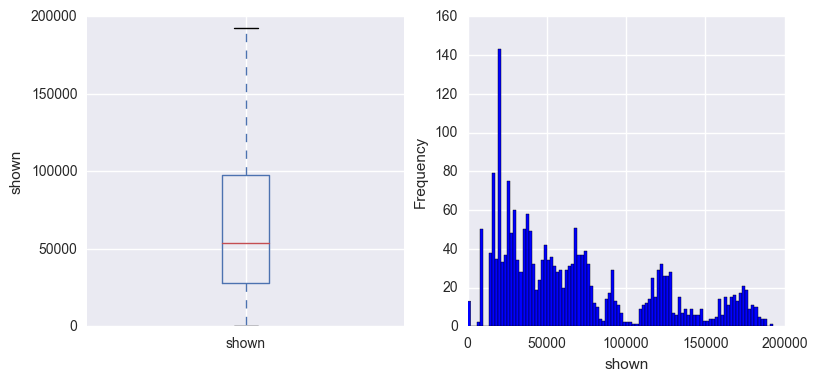

In [6]:
# Shown:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
df.shown.plot.box(ax = axes[0])
df.shown.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("shown")
axes[1].set_xlabel("shown")

For all the groups combined, the are no outliers in the 'shown' column and the values looks sensible.

<b> Clicked:

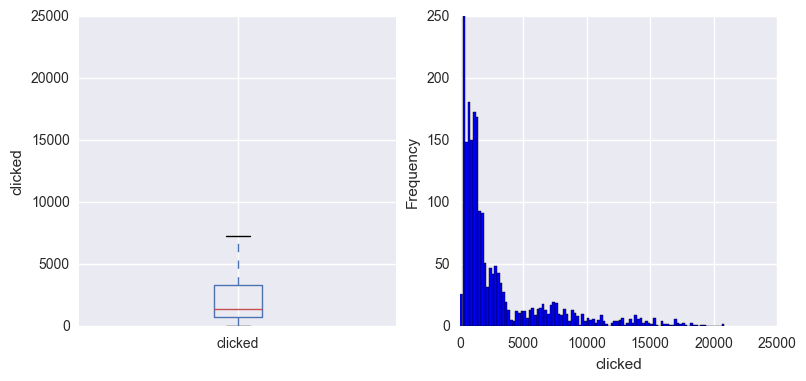

In [17]:
# Clicked:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
df.clicked.plot.box(ax = axes[0])
df.clicked.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("clicked")
axes[1].set_xlabel("clicked")

There are possible outliers in the 'clicked' column (refer to whiskers in the boxplot - left). 

In addition, we need to check for the condition 'clicked' <= 'shown'. It is impossible to have clicks more than the ads displayed.

In [13]:
df[ df['clicked'] > df['shown'] ]

Empty DataFrame
Columns: [date, shown, clicked, converted, avg_cost_per_click, total_revenue, ad]
Index: []

Great! The 'clicked' columns looks good. So far, there are no data violating the condition 'clicked' <= 'shown'.

<b> Converted:

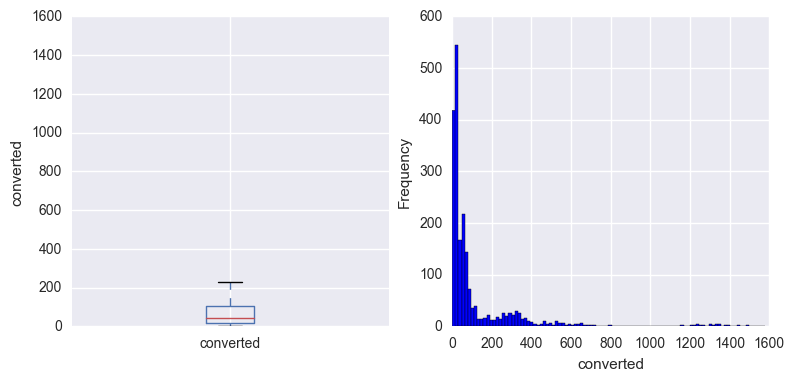

In [18]:
# converted:
fig, axes = plt.subplots(1, 2, figsize = (9, 4))
df.converted.plot.box(ax = axes[0])
df.converted.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("converted")
axes[1].set_xlabel("converted")

There are outliers in the 'converted' column as well. However, that could be related to specific group(s). Hence it requires further investigation. 

Again, the value should be less compared to the 'clicked' column. Lets check that.

In [16]:
df[df['converted'] > df['clicked']]

Empty DataFrame
Columns: [date, shown, clicked, converted, avg_cost_per_click, total_revenue, ad]
Index: []

Excellent! There are no data violating the condition 'converted' < 'clicked'.

<b> Average cost per click:

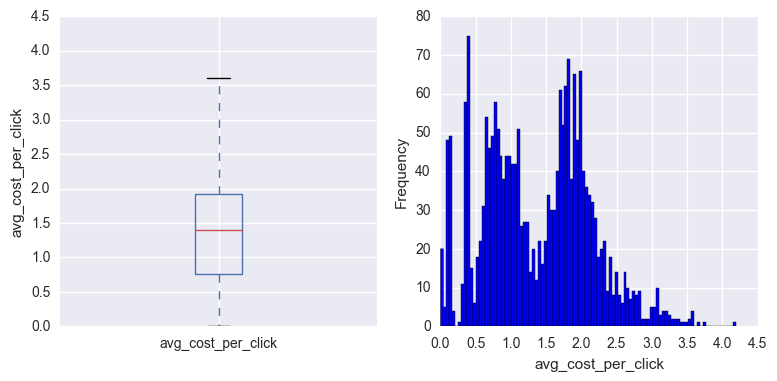

In [20]:
# avg_cost_per_click:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
df.avg_cost_per_click.plot.box(ax = axes[0])
df.avg_cost_per_click.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("avg_cost_per_click")
axes[1].set_xlabel("avg_cost_per_click")

Nice! The values makes sense. However, there may be few outliers. 

<b> Total Revenue:

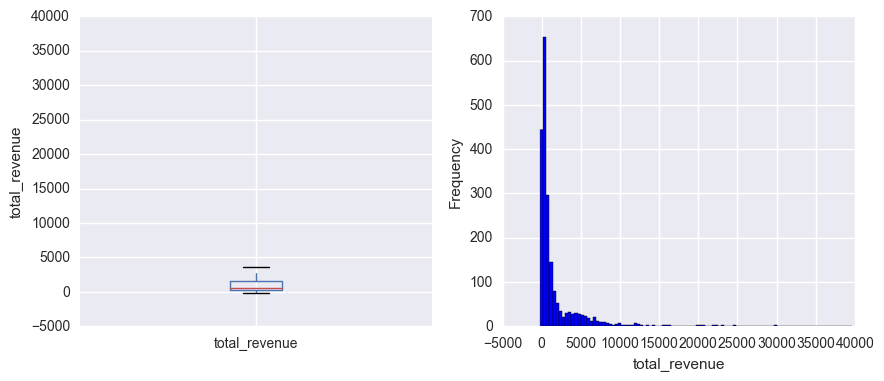

In [23]:
# total_revenue:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.total_revenue.plot.box(ax = axes[0])
df.total_revenue.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("total_revenue")
axes[1].set_xlabel("total_revenue")

There are lot of outliers in the data. However, it requires further investigation.There may not be any when we analyze for each group. 

Does the 'total_revenue' has negative values?

In [8]:
df[df['total_revenue'] < 0]

date  shown  clicked  converted  avg_cost_per_click  total_revenue  \
1186 2015-10-25  50459     1904         97                0.89        -200.15   
1404 2015-11-01  70145      584         15                0.36         -25.09   
1524 2015-11-15  22070     1400         20                1.67          -3.56   
2089 2015-10-28  80270     1151         41                0.96         -92.06   

               ad  
1186  ad_group_23  
1404  ad_group_27  
1524  ad_group_29  
2089  ad_group_40

Is it possible to have negative values for the total_revenue? Yes, when the cost spent on advertisements (clicked) is more than the money gained from the purchases (converted). Therefore, the negative values are possible. 

## 4. Data distribution:

One more step in understanding the data is to know the amount of samples in each group. Are they equally distributed or one group has more samples than the other? This study will be helpful in data sampling step of modeling. It is important to sample the data that represents the population.

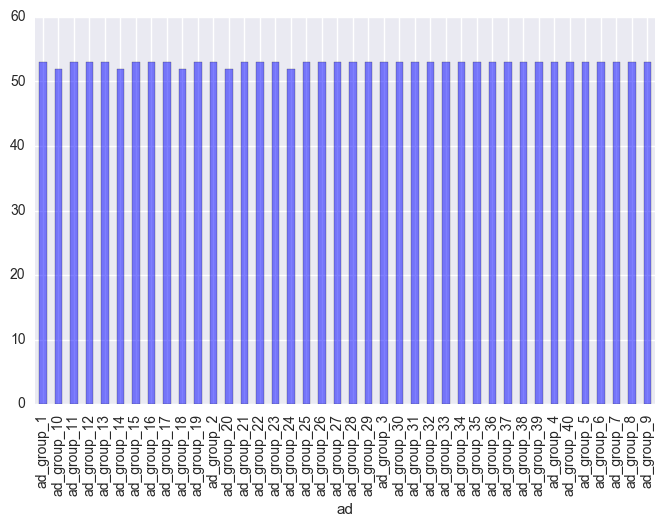

In [28]:
dff = df.groupby('ad')['shown'].count()
dff.plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))

The above bar chart clearly shows that we have almost equal number of data points for each ad group. So we could direct apply <i> random sampling technique (Monte Carlo) </i> to sample the data for modeling. 

In case, the data is not uniformly distributed among the different ad groups, then we have to apply <i> stratified sampling technique </i> to pick sample data that represents the actual population. It is important to note that the stratified sampling is only applicable when we have similar dependancies between variables in each group such that the group category can be ignored in modeling.

## 5. Scatter plot (grid):

It is important to understand the relation between variables for modeling. 

In case of 
1. 2 numerical variables, we can simple use scatter plot,
2. to study the relation between a numerical and a categorical variables we can use bar chart, and
3. to find the relation between 2 categorical variables, stacked column chart can be used.

<b> All numerical variables:

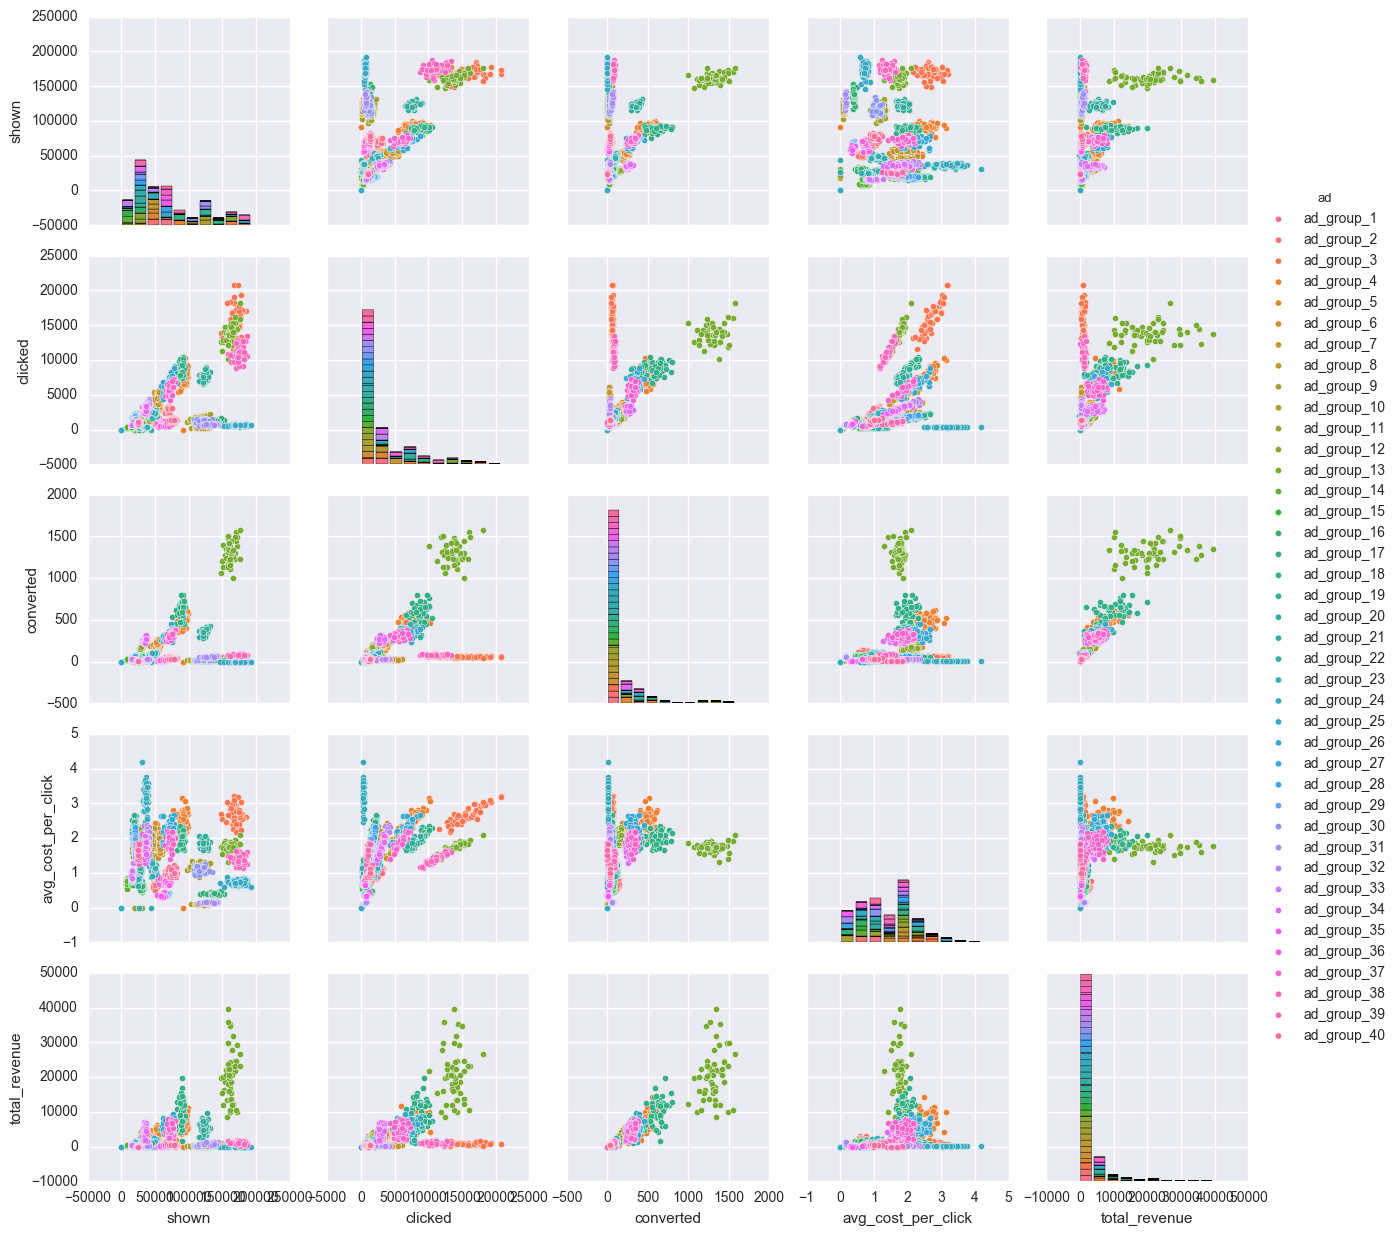

In [30]:
sns.pairplot(df[['shown', 'clicked', 'converted', 'avg_cost_per_click', 
                 'total_revenue', 'ad']], hue = 'ad')

Above pairplot shows no direct correlation between any of the variables in the table when data from all the groups combined are used. However, the plot shows clusters of data that might have linear and non-linear relationships between respective parameters. As we have multiple clusters in each of the above plots, when we segregate the data based on ad_group we might discover a relationship between the parameters

<b> Ad group 1: </b>

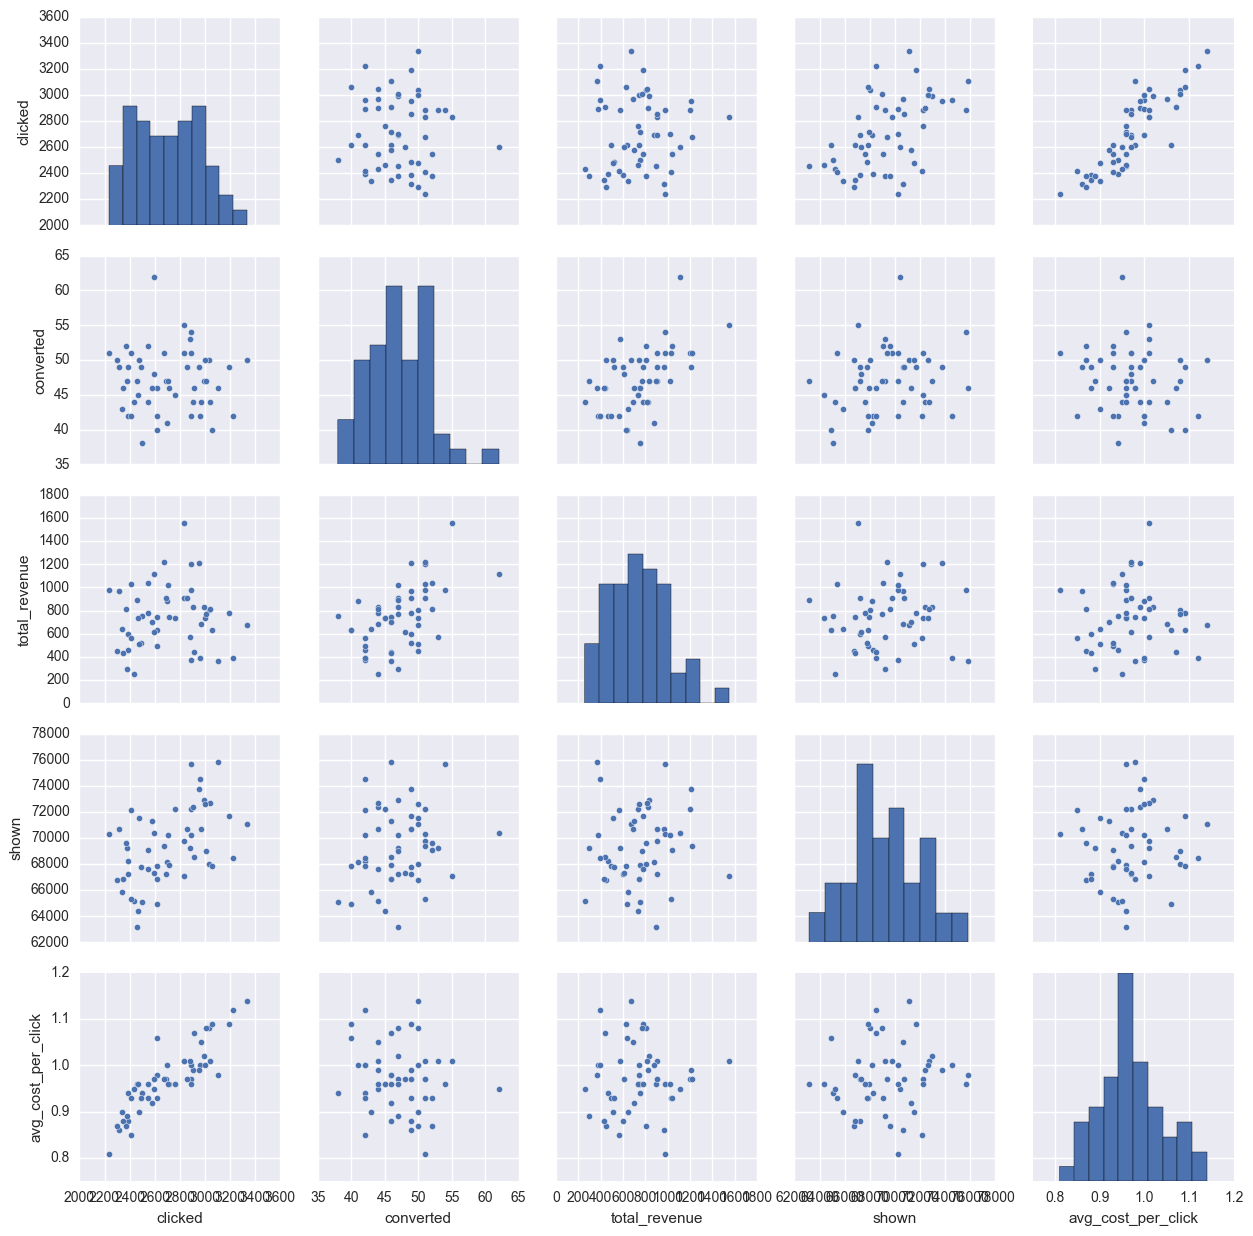

In [32]:
sns.pairplot(df.ix[df['ad'] == 'ad_group_1', {'shown', 'clicked', 'converted', 
                                              'avg_cost_per_click', 'total_revenue'}])

Simply by looking at the plot, we find that the 'clicked' and 'avg_cost_per_click' are linealy correlated

<b> Ad group 5: </b>

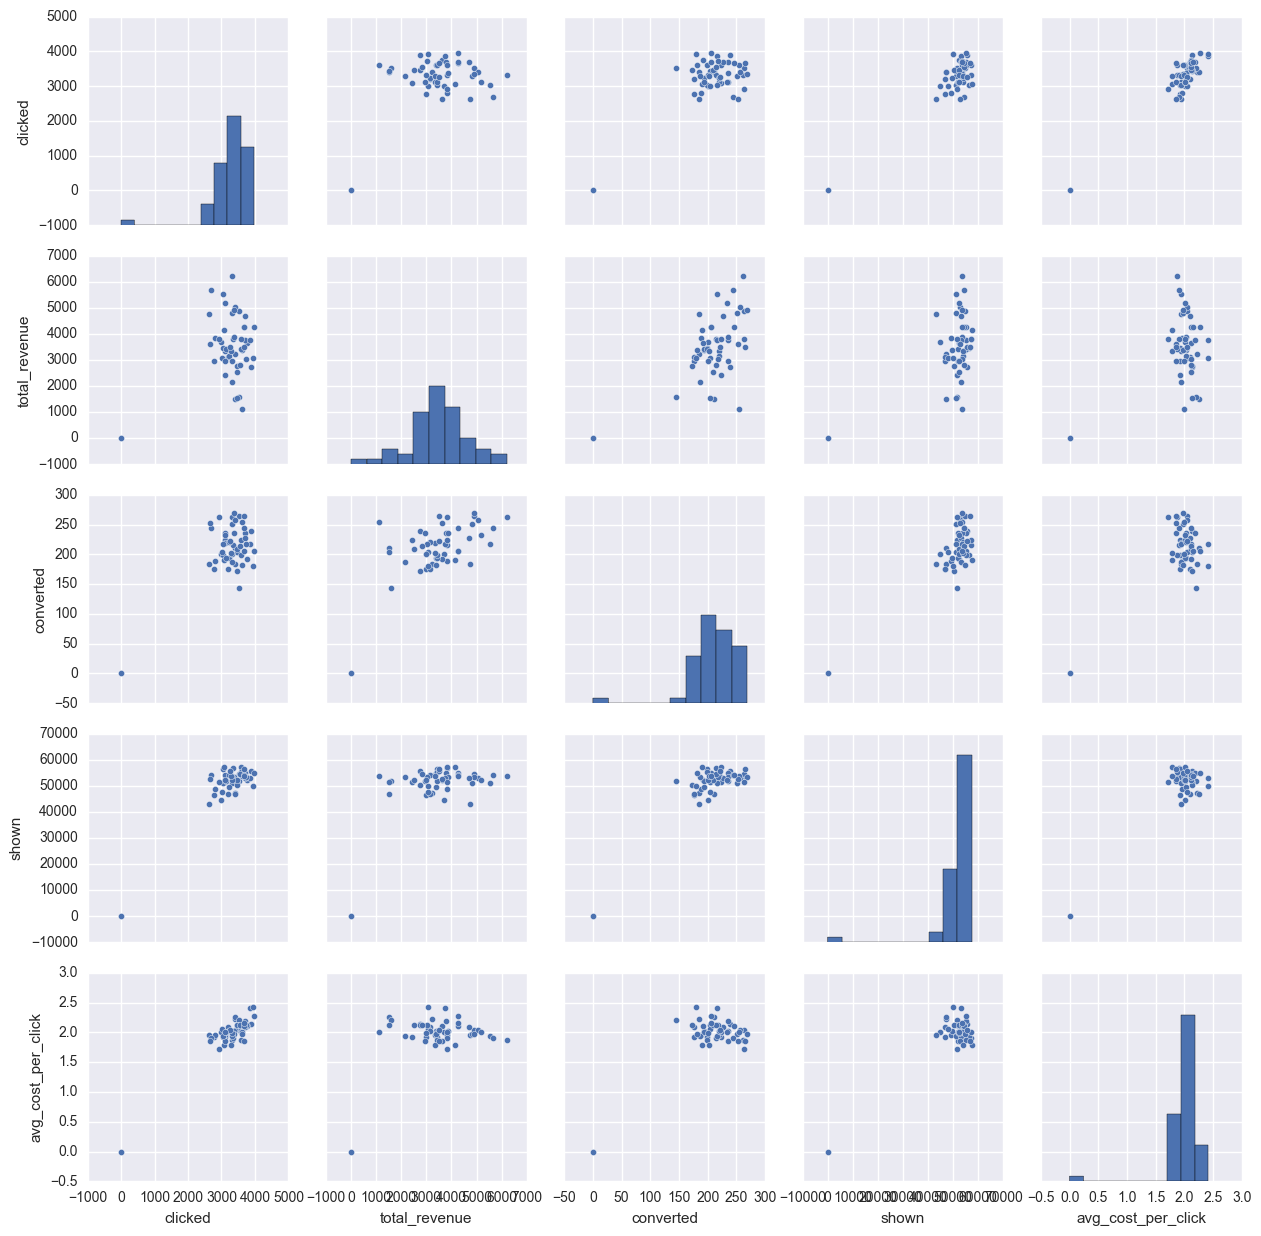

In [32]:
sns.pairplot(df.ix[df['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                              'avg_cost_per_click', 'total_revenue'}])

In the above plot for the ad_group 5 there are few outliers that could totally change the fitting curve or the model. So it is imperative to remove the outliers before proceding to the modeling step.

Again when we look at the plot with all the groups combined then we may not be able to identify these outliers as it could overlap with any other groups data. Therefore I am going to segregate the data based on groups and remove the outliers. 

# Data Preparation

## 1. Data cleanup - outliers:

Find the ratio of outliers, if insignificant just drop them or replace them with appropriate values

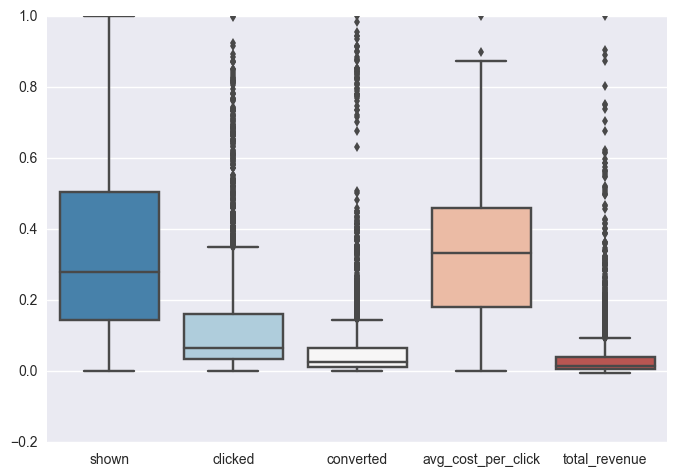

In [45]:
s = df[['shown', 'clicked', 'converted', 'avg_cost_per_click','total_revenue']]
ss = s / s.max()
sns.boxplot(ss, palette = 'RdBu_r')

When the data from all the groups are used to find the outliers, we get 100s of data points that are outside 3 standard deviations limit (~99.5 percentile limit). When we remove them blindly then we might accidentally drop many useful observations from the data. Therefore, I check for outliers in each group.

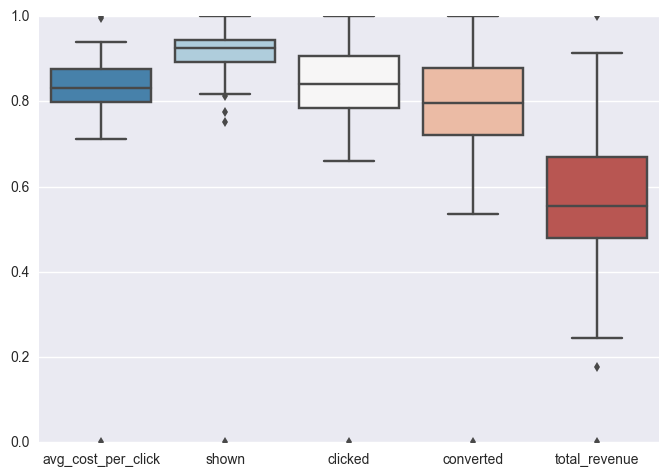

In [40]:
s = df.ix[df['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                     'avg_cost_per_click','total_revenue'}]
ss =  s / s.max()
sns.boxplot(ss, palette = 'RdBu_r')

In the above plot for the group 5, the outliers are just few and clearly distinct. Most importantly, it makes sense to remove outliers based on each group rather than all groups combined.

<b> Outliers Removal:

In [124]:
dff = df.copy(deep = True)

In [72]:
def remove_outliers(x):
    return x[(np.abs(stats.zscore(x)) < 3).all(axis = 1)]

In [125]:
columns = {'shown', 'clicked', 'converted', 'avg_cost_per_click','total_revenue'}
index_tobe_removed = []
# Implemented the follwing method as we have some columns with std == 0
for grp in dff.ad.unique():
    index_before = dff.ix[dff['ad'] == grp, columns].index.values # Index of each column
    dd_cols_std = dff.ix[(dff['ad'] == grp)].std() # columns to be considered
    dd_cols = list(dd_cols_std[dd_cols_std > 0].index.values) # removed cols with 0 std
    dd = remove_outliers( dff.ix[ (dff['ad'] == grp), dd_cols] )
    
    index_after = dd.index.values
    index_tobe_removed.extend(list(set(index_before) - set(index_after)))
    
print(index_tobe_removed)

"""
1. Done this way because df(length = n) == df(length < n) - not possible to replace df of unequal
lengths. If it replacing with statistical mean or mode, it could be simply assigned (replaced). So select
only the indices of the data to be removed.
2. std is checked for each column separately and columns with same values is dropped otherwise all the
values are assumed to be outside 3 std limit as the std = 0. Then we will endup deleting the entire group
"""

[17, 28, 201, 204, 223, 525, 554, 570, 566, 580, 632, 607, 650, 676, 811, 821, 893, 899, 1000, 1005, 1057, 1091, 1211, 1175, 1215, 1273, 1471, 1556, 1697, 1737, 1744, 1843, 1852, 1928, 2089, 2062]


The data in above indices are deleted to remove the outliers in the data

Lets verify using scatter plot or boxplot

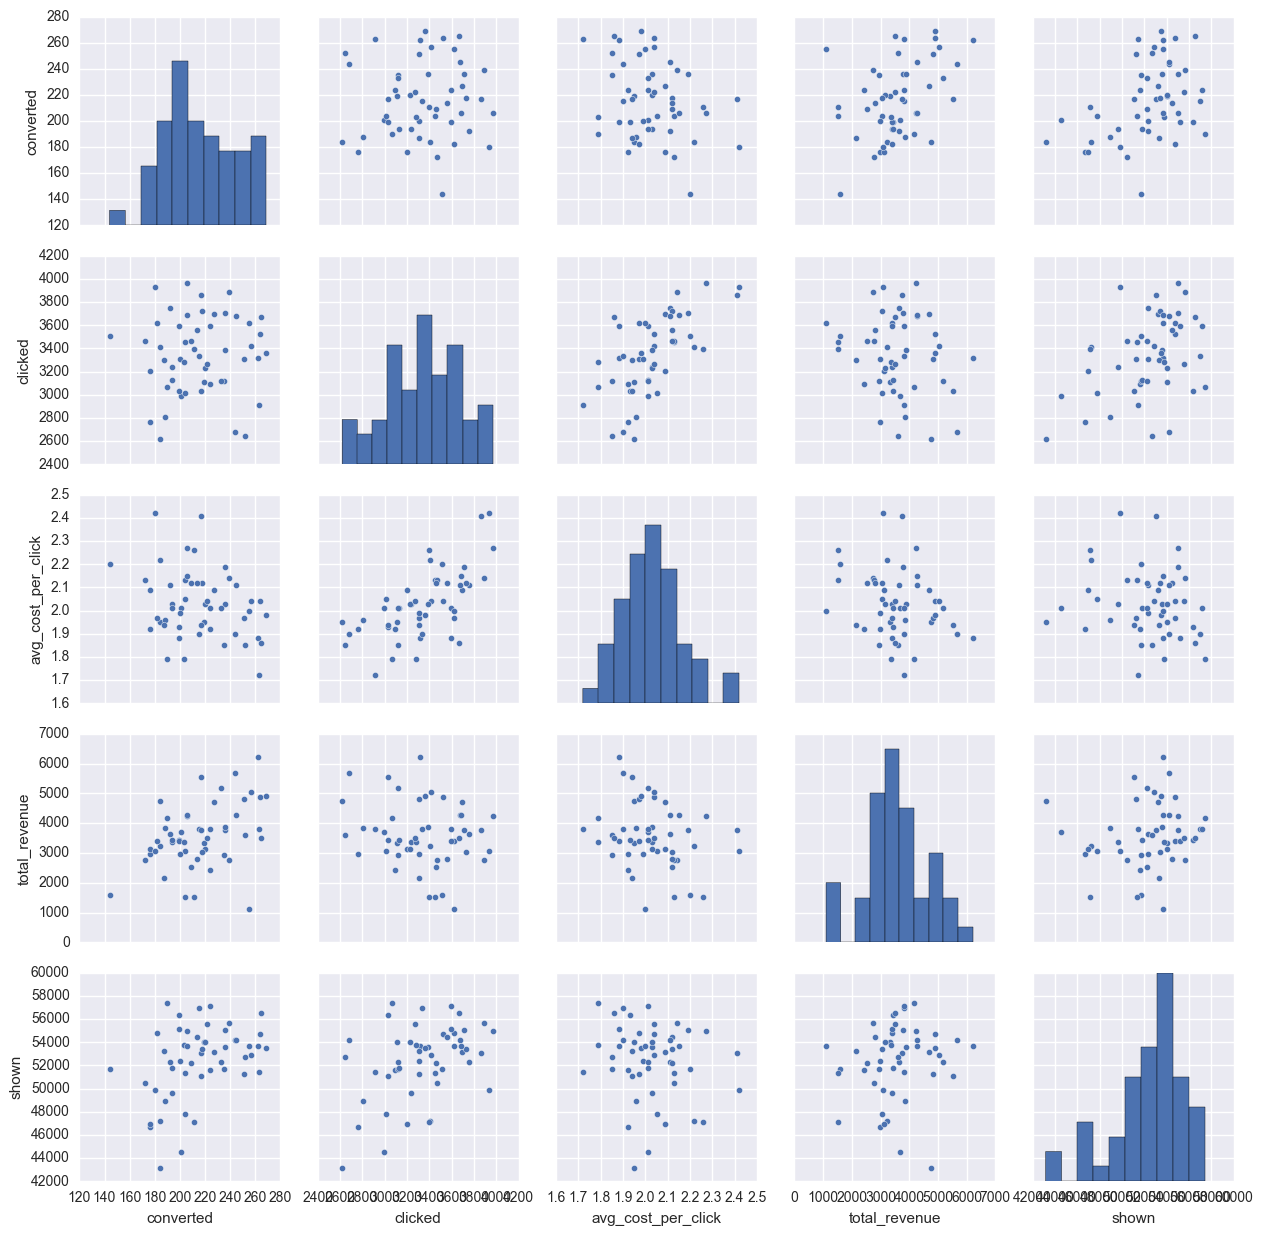

In [10]:
sns.pairplot(dff.ix[dff['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                                'avg_cost_per_click', 'total_revenue'}])

Great! Outliers are removed.

# Feature Engineering:

Let's add new variables that will be helpful for developing an accurate model

## Adding metrics - CTR and CR:

In [ ]:
dff['CTR'] = dff['clicked'] / dff['shown']
dff['CR'] = dff['converted'] / dff['clicked']

## Info from timestamps:

In [5]:
US_holidays = holidays.US()
dff['business_day'] = [isbday(x, US_holidays) for x in dff['date']]
dff['Week_day'] = [ x.weekday() for x in dff['date']]
# Same as Week_day column but with day names instead of nominal values. Only for exploration.
dff['Week_day_name'] = [calendar.day_name[x] for x in dff['Week_day']]
dff.head()

date  shown  clicked  converted  avg_cost_per_click  total_revenue  \
0 2015-10-01  65877     2339         43                0.90         641.62   
1 2015-10-02  65100     2498         38                0.94         756.37   
2 2015-10-03  70658     2313         49                0.86         970.90   
3 2015-10-04  69809     2833         51                1.01         907.39   
4 2015-10-05  68186     2696         41                1.00         879.45   

           ad       CTR        CR business_day  Week_day Week_day_name  
0  ad_group_1  0.035506  0.018384         True         3      Thursday  
1  ad_group_1  0.038372  0.015212         True         4        Friday  
2  ad_group_1  0.032735  0.021185        False         5      Saturday  
3  ad_group_1  0.040582  0.018002        False         6        Sunday  
4  ad_group_1  0.039539  0.015208         True         0        Monday

<b>CTR</b> - Click-through rate<br>
<b>CR</b> - Conversion rate<br>
<b>business_day</b> - working day (1) or holiday (0)<br>
<b>Week_day</b> - Day of the week (0-6 -> Monday to Sunday)<br>
<b>Week_day_name</b> - Name of the weekday

Does weekday and holiday category correlates to the target variable??

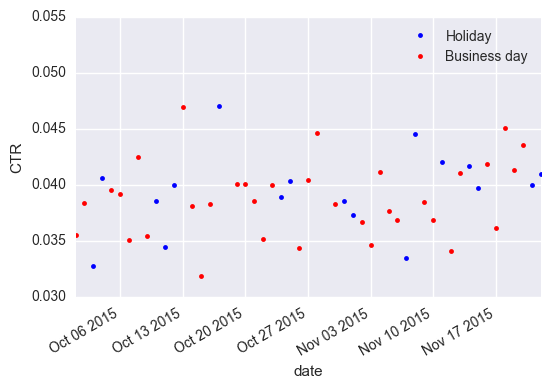

In [5]:
plt.figure()
ax = dff.ix[(dff.ad == 'ad_group_1') & (dff['business_day'] == 0)].plot('date', 'CTR', 
                                                                         style = 'b.', label = "Holiday")
dff.ix[(dff.ad == 'ad_group_1') & (dff['business_day'] == 1)].plot('date', 'CTR', 
                                                                    style = 'r.', ax = ax, 
                                                                    label = "Business day")
ax.set_ylabel("CTR")
ax.set_ylim(0.03, 0.055)
plt.legend()
plt.show()

In [6]:
dff_Week_day_name = pd.DataFrame()
dff_Week_day_name['avg'] = dff.groupby(['ad', 'Week_day_name'])['CTR'].mean()
dff_Week_day_name['std'] = dff.groupby(['ad', 'Week_day_name'])['CTR'].std()
dff_Week_day_name = dff_Week_day_name.reset_index()
dff_Week_day_name.head()

ad Week_day_name       avg       std
0  ad_group_1        Friday  0.038979  0.002514
1  ad_group_1        Monday  0.038705  0.002479
2  ad_group_1      Saturday  0.038861  0.004519
3  ad_group_1        Sunday  0.039686  0.003150
4  ad_group_1      Thursday  0.036860  0.003864

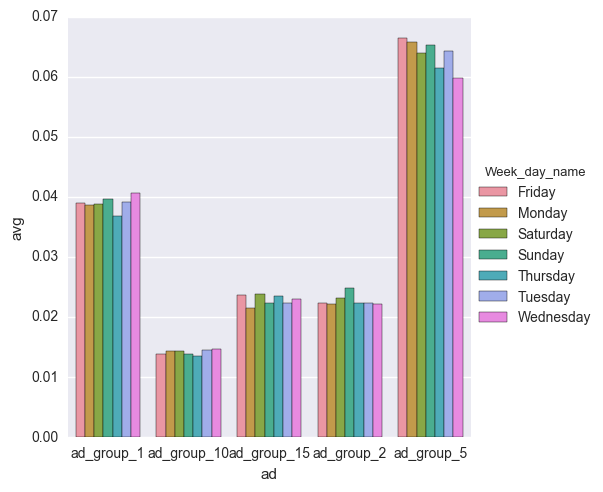

In [9]:
dd = dff_Week_day_name[dff_Week_day_name['ad'].isin(['ad_group_1', 'ad_group_2', 'ad_group_15', 
                                                     'ad_group_5', 'ad_group_10'])]
sns.factorplot(x = 'ad', y = 'avg', hue = 'Week_day_name', data = dd, kind="bar", size = 5)

In [10]:
dff_business_day = dff.groupby(['ad', 'business_day'])['CTR'].mean()
dff_business_day = dff_business_day.reset_index()
dff_business_day.head()

ad business_day       CTR
0   ad_group_1        False  0.039450
1   ad_group_1         True  0.038749
2  ad_group_10        False  0.014186
3  ad_group_10         True  0.014115
4  ad_group_11        False  0.064801

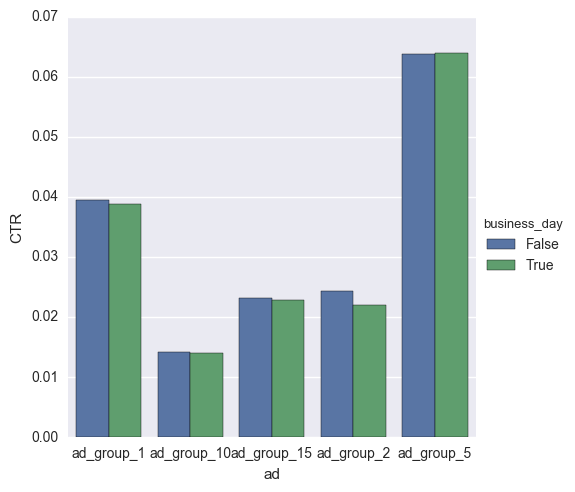

In [11]:
dd = dff_business_day[dff_business_day['ad'].isin(['ad_group_1', 'ad_group_2', 'ad_group_15', 'ad_group_5', 'ad_group_10'])]
sns.factorplot(x = 'ad', y = 'CTR', hue = 'business_day', data = dd, kind="bar", size = 5)

There is no correlation between weekday/business_day to CTR. Therefore we can drop those columns from the dataset

In [12]:
dff.drop(['business_day', 'Week_day', 'Week_day_name'], axis = 1, inplace = True)

## Other metrics

In [14]:
money_spent = dff['avg_cost_per_click'] * dff['clicked']

dff['CPC'] = money_spent / dff['converted']
dff['WS'] = (dff['clicked'] - dff['converted']) * dff['avg_cost_per_click']
dff['RCPC'] = dff['total_revenue'] / dff['clicked']

In [15]:
dff.head()

date  shown  clicked  converted  avg_cost_per_click  total_revenue  \
0 2015-10-01  65877     2339         43                0.90         641.62   
1 2015-10-02  65100     2498         38                0.94         756.37   
2 2015-10-03  70658     2313         49                0.86         970.90   
3 2015-10-04  69809     2833         51                1.01         907.39   
4 2015-10-05  68186     2696         41                1.00         879.45   

           ad       CTR        CR        CPC       WS      RCPC  
0  ad_group_1  0.035506  0.018384  48.955814  2066.40  0.274314  
1  ad_group_1  0.038372  0.015212  61.792632  2312.40  0.302790  
2  ad_group_1  0.032735  0.021185  40.595510  1947.04  0.419758  
3  ad_group_1  0.040582  0.018002  56.104510  2809.82  0.320293  
4  ad_group_1  0.039539  0.015208  65.756098  2655.00  0.326205

In [16]:
# Extremes of each of our metrics
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC - min: %.3f, max: %.3f" %(dff.CPC.min(), dff.CPC.max()))
print("WS - min: %.3f, max: %.3f" %(dff.WS.min(), dff.WS.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.124
CR - min: 0.000, max: 0.145
CPC - min: 1.034, max: inf
WS - min: 17.360, max: 66710.220
RCPC - min: -0.105, max: 2.900


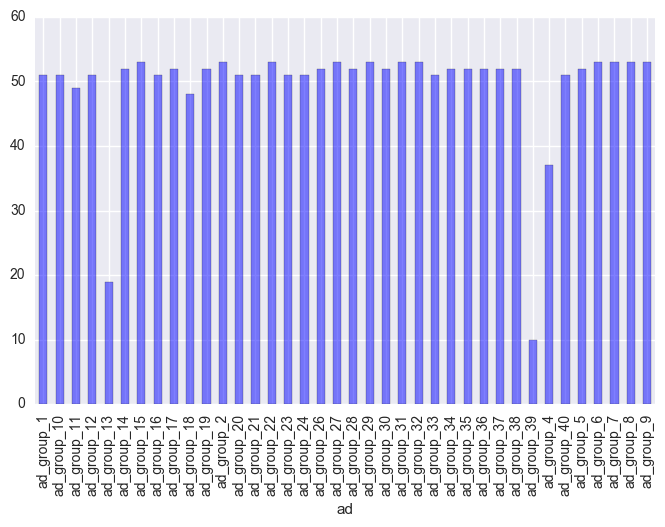

In [59]:
# Limiting metrics to its 95 percentile values
dfff = dff[(dff['WS'] < 21121) & (dff['CPC'] < 934)].groupby('ad')['shown'].count()
dfff.plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))

The Group_39 has High CPC and the Group_13 has High WS. So lets drop them

In [73]:
drop_list_ad_group = ['ad_group_13', 'ad_group_39']
dff = dff[ ~dff['ad'].isin(drop_list_ad_group) ].reset_index(drop = True)

In [76]:
# Now lets look at the range of all the individual metrics:
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC - min: %.3f, max: %.3f" %(dff.CPC.min(), dff.CPC.max()))
print("WS - min: %.3f, max: %.3f" %(dff.WS.min(), dff.WS.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.124
CR - min: 0.001, max: 0.145
CPC - min: 1.034, max: 1180.504
WS - min: 17.360, max: 66710.220
RCPC - min: -0.105, max: 2.868


On looking at the statistics of each metrics above, there is possibility that we have groups with much higher CPC and WS values compared to other groups. Lets find mean WS and CPC for each group and drop groups with high mean

In [95]:
aff = dff.groupby('ad')['WS'].mean()
bff = dff.groupby('ad')['CPC'].mean()

In [94]:
aff.sort_values(ascending = False).head(10)

ad
ad_group_3     43370.961698
ad_group_4     18841.019412
ad_group_18    16600.690392
ad_group_38    15268.214340
ad_group_26    14089.320000
ad_group_20    13138.984118
ad_group_37    10728.972115
ad_group_7      8865.924340
ad_group_32     6588.757925
ad_group_5      6372.208462
Name: WS, dtype: float64

In [96]:
bff.sort_values(ascending = False).head(10)

ad
ad_group_3     756.691659
ad_group_7     360.033043
ad_group_24    329.302925
ad_group_32    252.578300
ad_group_38    198.540031
ad_group_35    193.631154
ad_group_29    111.123743
ad_group_10    102.011993
ad_group_6      93.020708
ad_group_19     87.362560
Name: CPC, dtype: float64

ad_group_3 has both high WS and high CPC - drop it <br>
ad_group_38 has high WS and high CPC - drop it <br>
ad_group_4 high WS - drop it <br>
ad_group_18 high WS - drop it <br>

In [102]:
drop_list_ad_group = ['ad_group_3', 'ad_group_38', 'ad_group_4', 'ad_group_18']
dff = dff[ ~dff['ad'].isin(drop_list_ad_group) ].reset_index(drop = True)

In [104]:
# Now lets look at the range of all the individual metrics:
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC - min: %.3f, max: %.3f" %(dff.CPC.min(), dff.CPC.max()))
print("WS - min: %.3f, max: %.3f" %(dff.WS.min(), dff.WS.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.113
CR - min: 0.001, max: 0.145
CPC - min: 1.034, max: 565.544
WS - min: 17.360, max: 22291.800
RCPC - min: -0.105, max: 2.868


Now that we removed the outliers. Lets go ahead and apply normalization technique to the metric.

## Normalization of the metrics

In [4]:
dff['CPC_1'] = 1/dff['CPC']
dff['WS_1'] = 1/dff['WS']

In [5]:
# Now lets look at the range of all the individual metrics:
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC_1 - min: %.3f, max: %.3f" %(dff.CPC_1.min(), dff.CPC_1.max()))
print("WS_1 - min: %.3f, max: %.3f" %(dff.WS_1.min(), dff.WS_1.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.113
CR - min: 0.001, max: 0.145
CPC_1 - min: 0.002, max: 0.967
WS_1 - min: 0.000, max: 0.058
RCPC - min: -0.105, max: 2.868


We want all 5 to be on the same scale so that all carries the same weight when used on computing the QF. This can be achieved by applying minmax scaler from sklearn module on each of these metrics

In [15]:
# Creating objects for each metric:
mm_scaler_CTR = MM()
mm_scaler_CR = MM()
mm_scaler_RCPC = MM()
mm_scaler_CPC_1 = MM()
mm_scaler_WS_1 = MM()

In [17]:
dff['CTR'] = mm_scaler_CTR.fit_transform(dff['CTR'])
dff['CR'] = mm_scaler_CR.fit_transform(dff['CR'])
dff['RCPC'] = mm_scaler_RCPC.fit_transform(dff['RCPC'])
dff['CPC_1'] = mm_scaler_CPC_1.fit_transform(dff['CPC_1'])
dff['WS_1'] = mm_scaler_WS_1.fit_transform(dff['WS_1'])

In [18]:
# Now lets look at the range of all the individual metrics:
print("CTR - min: %.3f, max: %.3f" %(dff['CTR'].min(), dff['CTR'].max()))
print("CR - min: %.3f, max: %.3f" %(dff['CR'].min(), dff['CR'].max()))
print("CPC - min: %.3f, max: %.3f" %(dff['CPC_1'].min(), dff['CPC_1'].max()))
print("WS - min: %.3f, max: %.3f" %(dff['WS_1'].min(), dff['WS_1'].max()))
print("RCPC - min: %.3f, max: %.3f" %(dff['RCPC'].min(), dff['RCPC'].max()))

CTR - min: 0.000, max: 1.000
CR - min: 0.000, max: 1.000
CPC - min: 0.000, max: 1.000
WS - min: 0.000, max: 1.000
RCPC - min: 0.000, max: 1.000


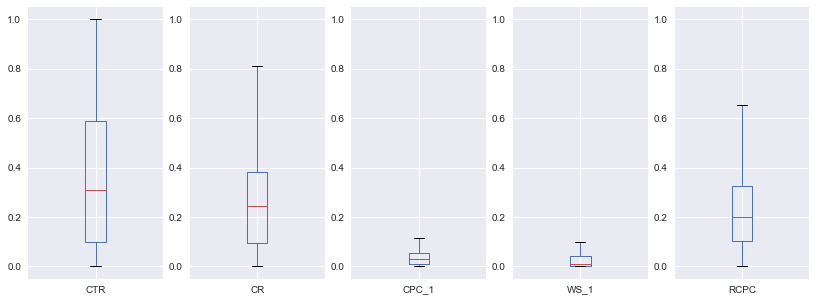

In [19]:
plts, ax = plt.subplots(1, 5, figsize = (14, 5))
dff['CTR'].plot.box(ax = ax[0])
dff['CR'].plot.box(ax = ax[1])
dff['CPC_1'].plot.box(ax = ax[2])
dff['WS_1'].plot.box(ax = ax[3])
dff['RCPC'].plot.box(ax = ax[4])

## Quality factor:

In [21]:
dff['QF'] = dff[['CTR','CR', 'RCPC', 'CPC_1', 'WS_1']].mean(axis = 1)

In [22]:
dff[['CTR', 'CR', 'CPC', 'WS', 'RCPC', 'QF']].head(10)

CTR        CR        CPC       WS      RCPC        QF
0  0.304341  0.121223  48.955814  2066.40  0.127626  0.116030
1  0.330098  0.099130  61.792632  2312.40  0.137204  0.117621
2  0.279443  0.140731  40.595510  1947.04  0.176547  0.125712
3  0.349963  0.118564  56.104510  2809.82  0.143091  0.126732
4  0.340587  0.099099  65.756098  2655.00  0.145080  0.120892
5  0.336995  0.115605  55.753478  2519.58  0.131302  0.121354
6  0.300068  0.115576  53.490476  2207.12  0.100425  0.108140
7  0.366792  0.103315  67.665870  3063.41  0.086382  0.114973
8  0.303973  0.136276  42.832653  2055.68  0.120278  0.118112
9  0.331369  0.105087  57.881429  2391.96  0.098480  0.111498

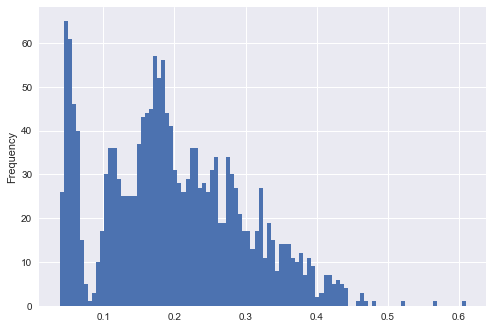

In [23]:
dff['QF'].plot.hist(bins = 100)

<b> Note :</b> Higher the QF better the performance

In [24]:
ranks = dff.groupby('ad')['QF'].mean()
ranks = ranks.reset_index().set_index('ad', drop = True)

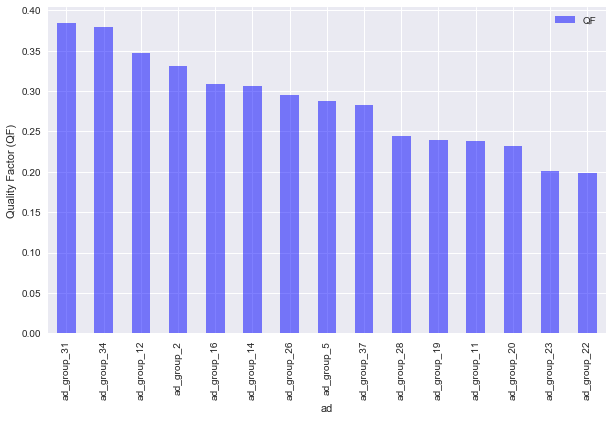

In [28]:
ax = ranks.sort('QF', ascending = False)[:15].plot.bar(color = 'b', alpha = 0.5, figsize = (10, 6))
ax.set_ylabel("Quality Factor (QF)")

Remember, the goal is to identify the top groups in terms of performance. Lets say top 5.

In [54]:
ranks.sort('QF', ascending = False)[:5].index.values.tolist() # Ranked in order

['ad_group_13', 'ad_group_34', 'ad_group_18', 'ad_group_2', 'ad_group_16']

From the above bar chart, it is evident that the top 5 best performing Ad campaigns are 
<b> 
1. ad_group_13
2. ad_group_34
3. ad_group_12
4. ad_group_2
5. ad_group_16

----------------------------------------------------------------------------------------------------

# 2. Time-series Modeling and Forecast

<b> Goal:</b> For each group predict, <b> how many ads will be shown on a particular date </b> by assuming that each group follows its trend.

For time-series forecasting, the only parameter that will be available for forecasting is the date.

In [250]:
df_prediction = dff.copy( deep = True )
df_prediction = df_prediction[['shown', 'ad']]

It is important to note down that there are more than 30 groups in the data and it is mandatory to segregate them before checking for any time-series properties and applying methods for forecasting.

In [4]:
df_prediction.ix['2015-10-01'].head(10)

shown           ad
date                           
2015-10-01   65877   ad_group_1
2015-10-01   50988   ad_group_2
2015-10-01   44544   ad_group_5
2015-10-01   33559   ad_group_6
2015-10-01   48431   ad_group_7
2015-10-01   38089   ad_group_8
2015-10-01  102898   ad_group_9
2015-10-01   97590  ad_group_10
2015-10-01   16451  ad_group_11
2015-10-01   26000  ad_group_12

In a time-series modeling the step is usually checking for stationarity of the data. If the data is not stationary it is important to make the data stationary and then apply model. However there are models that can directly handle non-stationary data and build model but they have their own limitations and flexibility.

## Adfuller test

Adfuller test is one of the most commonly used test to check for stationary data. Although, from the plot of the time-series data for 'shown' it is clear that there is no periodic trend (or seasonality) in the data, lets apply 'Augmented Dickey-Fuller test' for each group to check if the data is stationary

In [11]:
result = adfuller(df_prediction[df_prediction['ad'] == 'ad_group_1'].shown.values)

In [12]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.371359
p-value: 0.000333
Critical Values:
	5%: -2.921
	10%: -2.599
	1%: -3.568


<b> Null hypothesis:</b> The time-series data is non-stationary. 

As the p-value is < 0.05 the null hypothesis can be rejected. Hence the time-series data is stationary.

In [5]:
unique_groups = df_prediction['ad'].unique()

In [47]:
# Lets check stationarity on all the groups
ad_fuller_pvalue = {}
for grp in unique_groups:
    result = adfuller(df_prediction[df_prediction['ad'] == grp].shown.values)
    ad_fuller_pvalue[grp] = result[1]
    
ad_fuller_pvalue = [(k, v) for k, v in ad_fuller_pvalue.items()]
ad_fuller_pvalue = pd.DataFrame.from_records(ad_fuller_pvalue)
ad_fuller_pvalue.columns = ['group', 'p_value']
ad_fuller_pvalue = ad_fuller_pvalue.set_index('group', drop = True)

In [48]:
ad_fuller_pvalue.sort_index().head()

p_value
group                
ad_group_1   0.000333
ad_group_10  0.019041
ad_group_11  0.006558
ad_group_12  0.000203
ad_group_14  0.001133

In [49]:
ad_fuller_pvalue[ad_fuller_pvalue.p_value > 0.05]

p_value
group                
ad_group_24  0.088362

There is one non-stationary group. So lets apply ARIMA model first and check the results.

## ARMA / ARIMA Modeling

<b> Parameters involved:

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5)<br>
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value<br>
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

### Identify p and q values:

#### 1. ACF and PACF plots:

ACF - to identify q-value(MA part) <br>
PACF - to identify p-value(AR part)

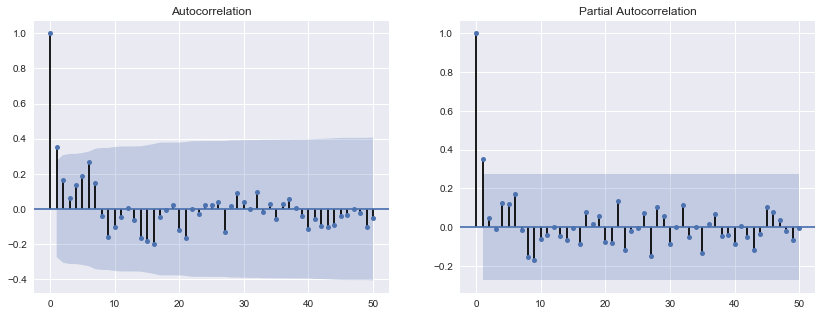

In [321]:
dd = df_prediction.ix[df_prediction.ad == 'ad_group_1', {'shown'}]
figs, axes = plt.subplots(1, 2, figsize = (14, 5))
plot_acf(dd, ax = axes[0])
plot_pacf(dd, ax = axes[1])
plt.show()

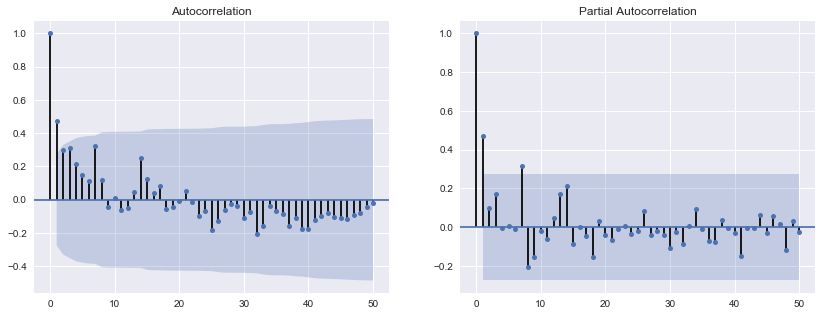

In [322]:
# Non-stationary group:
dd = df_prediction.ix[df_prediction.ad == 'ad_group_24', {'shown'}]
figs, axes = plt.subplots(1, 2, figsize = (14, 5))
plot_acf(dd, ax = axes[0])
plot_pacf(dd, ax = axes[1])
plt.show()

#### 2. Using "arma_order_select_ic" in python:

In [328]:
ddf = df_prediction.ix[df_prediction.ad == 'ad_group_24', {'shown'}].copy(deep = True)

arma_summary = arma_order_select_ic(ddf, ic=['aic'], trend='nc',
                                    max_ar = 10, max_ma = 5, fit_kw = {'method': 'css'})
print(arma_summary['aic_min_order'])

(10, 0)


<i> This method will be helpful to automate the process and identify optimal parameters for each ad group

### Modeling

In [6]:
# Function to find optimal parameters based on 'aic' criterion
def get_arma_params(grp):
    ddf = df_prediction.ix[df_prediction.ad == grp, {'shown'}].copy(deep = True)
    x = arma_order_select_ic(ddf, ic=['aic'], trend='nc',
                             max_ar = 10, max_ma = 5, fit_kw = {'method': 'css'})
    return x['aic_min_order']

In [8]:
ARMA_parameters = {}
for grp in unique_groups:
    ARMA_parameters[grp] = get_arma_params(grp)

ARMA_parameters = pd.DataFrame.from_dict(ARMA_parameters).T
ARMA_parameters = ARMA_parameters.apply(tuple, axis = 1)

In [9]:
ARMA_parameters.head()

ad_group_1     (10, 0)
ad_group_10    (10, 0)
ad_group_11    (10, 0)
ad_group_12    (10, 0)
ad_group_14     (9, 5)
dtype: object

<b> ARIMA

Let's build a model for one of the groups before automating the process

In [59]:
data = df_prediction.ix[df_prediction.ad == 'ad_group_24', 'shown'].copy(deep = True)
data = data.resample('1D').first() # Raises an exception if the freq of the datetime series is None
data = data.interpolate(axis = 0, limit = 2).dropna()

In [60]:
#Optimal parameter for ad_group 24
ARMA_parameters['ad_group_24']

(10, 0)

In [61]:
# Assuming d = 1
ARIMA_model = tsa.ARIMA(data, order = (10, 1, 0))
ARIMA_model = ARIMA_model.fit(trend = 'nc')

In [62]:
print(ARIMA_model.params)
print(ARIMA_model.aic, ARIMA_model.bic, ARIMA_model.hqic)

ar.L1.D.shown    -0.542377
ar.L2.D.shown    -0.528573
ar.L3.D.shown    -0.300240
ar.L4.D.shown    -0.318310
ar.L5.D.shown    -0.167567
ar.L6.D.shown    -0.234754
ar.L7.D.shown     0.233798
ar.L8.D.shown     0.075148
ar.L9.D.shown     0.015403
ar.L10.D.shown    0.032247
dtype: float64
907.0659399819505 928.316021942 915.186224805


<b> Construct parameters for ARIMA modeling

In [10]:
temp_params = [ (x, y + (0,)) if not x == 'ad_group_24' else (x, y + (1,))
                for x, y in ARMA_parameters.iteritems()]
ARIMA_parameters = { x: (y[0],)+(y[2],)+(y[1],) for x, y in temp_params}

<b> ARIMA Model for each group:

In [ ]:
fitted_model = {}
failed_grps = []
for grp in unique_groups:
    try:
        ddf = df_prediction.ix[df_prediction.ad == grp, {'shown'}].copy(deep = True)
        ddf = ddf.resample('1D').first() # Raises an exception if the freq of the datetime series is None
        ddf = ddf.interpolate(axis = 0, limit = 2).dropna()

        ARIMA_model = tsa.ARIMA(ddf, order = ARIMA_parameters[grp])
        fitted_model[grp] = ARIMA_model.fit(trend = 'nc')
    except Exception as e:
        print(grp, ARIMA_parameters[grp], e)
        failed_grps.append(grp)
    del ddf

Great! Now we have optimal parameters and a time-series model to predict the ads shown on a particular day

<b> Sample plot with forecast:

In [73]:
group_ = 'ad_group_12'
ddf = df_prediction.ix[df_prediction.ad == group_, {'shown'}].copy(deep = True)
ddf = ddf.resample('1D').first() # Raises an exception if the freq of the datetime series is None
ddf = ddf.interpolate(axis = 0, limit = 2).dropna()

try:
    ARMA_predict = fitted_model[group_].predict('2015-11-15', '2015-12-15',
                                                       dynamic = False, typ = 'levels')
except TypeError:
    ARMA_predict = fitted_model[group_].predict('2015-11-15', '2015-12-15', dynamic = False)

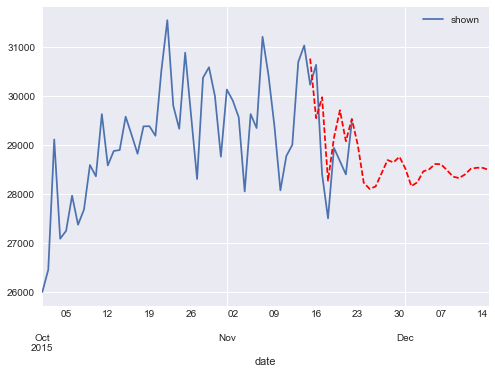

In [74]:
plt.figure(figsize = (6, 4))
ddf.plot()
ARMA_predict.plot(style = '--r')
plt.show()

## Forecasting
the ad shown on a particular date

In [71]:
date = '2015-12-15'
predict_shown = {}
for grp in unique_groups:
    try:
        try:
            prediction = fitted_model[grp].predict('2015-11-10', '2015-12-15',
                                                   dynamic = False, typ = 'levels')
        except:
            prediction = fitted_model[grp].predict('2015-11-10', '2015-12-15', dynamic = False)
    except Exception as e:
        print(e)
    predict_shown[grp] = prediction.ix[date]

In [72]:
predict_shown

{'ad_group_1': 72756.336008315178,
 'ad_group_10': 120255.67978867622,
 'ad_group_11': 20381.27463778514,
 'ad_group_12': 28492.849423255342,
 'ad_group_14': 8996.8355889479317,
 'ad_group_15': 15828.802673892207,
 'ad_group_16': 30445.466625372686,
 'ad_group_17': 139948.84289518395,
 'ad_group_19': 22124.917450909514,
 'ad_group_2': 51087.157637690572,
 'ad_group_20': 122302.3834287223,
 'ad_group_21': 28020.193930302135,
 'ad_group_22': 25955.849590401769,
 'ad_group_23': 47214.287080401009,
 'ad_group_24': 37596.669093945435,
 'ad_group_26': 85396.52721505634,
 'ad_group_27': 65727.080925157585,
 'ad_group_28': 20905.271315895756,
 'ad_group_29': 20731.587667494503,
 'ad_group_30': 119033.0691107358,
 'ad_group_31': 102894.44010366594,
 'ad_group_32': 39899.220374192235,
 'ad_group_33': 16432.553129319567,
 'ad_group_34': 36612.824788393154,
 'ad_group_35': 3014.0960833989629,
 'ad_group_36': 68310.923702113185,
 'ad_group_37': 75466.797235614256,
 'ad_group_40': 76921.5990466371,


# 3. Clustering analysis:

Another best method to analyze, understand, and predict an ad_group's behaviour is using clustering analysis. One of the well-knowm and commonly used clustering methods is k-means clustering.

Lets cluster the groups into 3 based on 'avg_cost_per_click' (increases, no change, decreases)

In [109]:
x = cluster_data.pivot(columns = 'ad', values = 'avg_cost_per_click')
x = x.interpolate(axis = 0)
x = x.fillna(method = 'bfill')
x = x.stack().unstack(level = 0)

In [133]:
# Normalization
x = x.div(x.max(axis = 1), axis = 0)

Now all the groups are normalized

### k-means clustering

In [80]:
from sklearn.cluster import KMeans

Now lets find the slope of variance of each ad_group and feed that as input for kmeans

In [149]:
from sklearn.linear_model import LinearRegression as lr

In [222]:
def get_slope(grp):
    data = cluster_data.ix[cluster_data['ad'] == grp, 'avg_cost_per_click'].sort_index()
    LR = lr() # linear regression
    X = np.linspace(0, 1, len(data)).reshape(len(data), 1)
    y = data.values.reshape(len(data), 1)
    LR.fit(X, y)
    return LR.coef_[0][0]

In [224]:
grp_slope = {}
for grp in unique_groups:
    grp_slope[grp] = get_slope(grp)

In [225]:
grp_slope

{'ad_group_1': 0.049366515837104108,
 'ad_group_10': 0.00045248868778277319,
 'ad_group_11': 0.02507755102040813,
 'ad_group_12': 0.044705882352941186,
 'ad_group_14': -0.04092888243831639,
 'ad_group_15': 0.021090146750524098,
 'ad_group_16': -0.031447963800904991,
 'ad_group_17': -0.0089912917271407957,
 'ad_group_19': -0.15054426705370103,
 'ad_group_2': -0.00033542976939201195,
 'ad_group_20': 0.033257918552036247,
 'ad_group_21': -0.053846153846153863,
 'ad_group_22': -0.012662473794549281,
 'ad_group_23': -0.027013574660633456,
 'ad_group_24': -0.21855203619909494,
 'ad_group_26': 0.037651991614255656,
 'ad_group_27': -0.015723270440251569,
 'ad_group_28': -0.10177793904209002,
 'ad_group_29': -0.066540880503144662,
 'ad_group_30': -0.0049201741654572011,
 'ad_group_31': 0.0041509433962264117,
 'ad_group_32': 0.22142557651991612,
 'ad_group_33': -0.075067873303167443,
 'ad_group_34': 0.001937590711175612,
 'ad_group_35': -0.03034833091436866,
 'ad_group_36': -0.064985486211901325

{'ad_group_1': 0.049366515837104108,
 'ad_group_10': 0.00045248868778277319,
 'ad_group_11': 0.02507755102040813,
 'ad_group_12': 0.044705882352941186,
 'ad_group_14': -0.04092888243831639,
 'ad_group_15': 0.021090146750524098,
 'ad_group_16': -0.031447963800904991, ... }

<b> Applying k-means clustering to all the groups

In [233]:
grp_slope = [(k, v) for k, v in grp_slope.items()]
grp_slope = pd.DataFrame.from_records(grp_slope, columns = ['group_id', 'slope'])
grp_slope = grp_slope.set_index('group_id', drop = True)
grp_slope.head()

slope
group_id            
ad_group_1  0.049367
ad_group_2 -0.000335
ad_group_5 -0.053599
ad_group_6 -0.090147
ad_group_7 -0.133585

In [234]:
kmeans = KMeans(n_clusters = 3)

In [235]:
kmeans.fit(grp_slope)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [236]:
kmeans.labels_

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 1, 0, 0, 1, 2, 2])

In [238]:
# Specify colors for each category
label_colrs = {0: 'r', 1: 'b', 2: 'g'}
label_colors = [label_colrs[x] for x in kmeans.labels_]

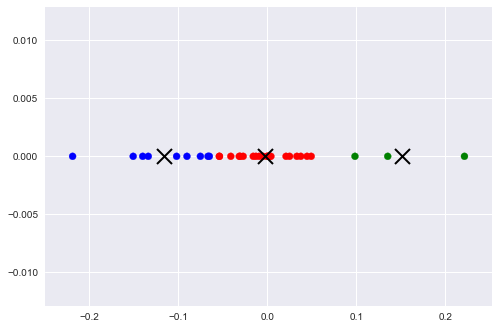

In [250]:
plt.figure()
plt.scatter(grp_slope.slope, np.zeros(len(grp_slope)), c = label_colors)

for i in range(kmeans.n_clusters):
    cross = plt.plot(kmeans.cluster_centers_[i][0], 0,'kx')
    plt.setp(cross, ms = 15.0)
    plt.setp(cross, mew = 2.0)

In [251]:
grp_slope['category'] = kmeans.labels_

In [253]:
kmeans.cluster_centers_

array([[-0.00284856],
       [-0.11567027],
       [ 0.15173846]])

In [254]:
category_label = {0: 'No change', 1: 'Goes down', 2: 'Goes up'}

In [258]:
grp_slope.category = grp_slope.category.replace(category_label)
grp_slope.head()

slope   category
group_id                       
ad_group_1  0.049367  No change
ad_group_2 -0.000335  No change
ad_group_5 -0.053599  No change
ad_group_6 -0.090147  Goes down
ad_group_7 -0.133585  Goes down